# Non-negative Matrix Factorization for Recommendations and Faces

This notebook implements non-negative matrix factorization (NMF) from scratch and applies it to two problems:
1. A toy grocery “customers × items” matrix for unsupervised recommendation.
2. A faces dataset, where each column is a vectorized grayscale image.

The project demonstrates numerical optimization, matrix factorization, and empirical evaluation of reconstruction quality on real image data.


## NMF recommender: model and optimization

I first implement an `NMFRecommender` class that factors a non-negative matrix $V \in \mathbb{R}^{m \times n}$ into $W \in \mathbb{R}^{m \times r}$ and $H \in \mathbb{R}^{r \times n}$ with $W, H \ge 0$.

The factorization minimizes the Frobenius norm $\lVert V - WH \rVert_F$ subject to non-negativity constraints, using an alternating convex optimization scheme with CVXPY updates for $W$ and $H$. This turns the non-convex NMF problem into a sequence of convex subproblems, with explicit convergence checks on successive iterates.



In [26]:
import numpy as np
import cvxpy as cp
from matplotlib import pyplot as plt
import os
import zipfile
from imageio.v3 import imread
import warnings
warnings.filterwarnings("ignore")
from sklearn.decomposition import NMF

In [27]:
class NMFRecommender:

    def __init__(self, random_state=15, rank=3, maxiter=200, tol=1e-3):
        """The parameter values for the algorithm"""

        self.random_state = random_state
        self.rank = rank
        self.maxiter = maxiter
        self.tol = tol

        
    
    def initialize_matrices(self, m, n):
        """randomly initialize the W and H matrices,"""

        np.random.seed(self.random_state)
        self.W = np.random.rand(m, self.rank)
        self.H = np.random.rand(self.rank, n)

        return self
    

      
    def fit(self, V):
        """Fits W and H weight matrices using CVXPY"""

        m, n = V.shape

        self.initialize_matrices(m, n)

        for iteration in range(self.maxiter):
            W_prev = self.W.copy()
            H_prev = self.H.copy()

            # Optimize W
            W_var = cp.Variable((m ,self.rank), nonneg=True)
            objective_W = cp.Minimize(cp.norm(V - W_var @ self.H, 'fro'))
            prob_W = cp.Problem(objective_W)
            prob_W.solve()
            self.W = W_var.value

            # Optimize H
            H_var = cp.Variable((self.rank, n), nonneg=True)
            objective_H = cp.Minimize(cp.norm(V - self.W @ H_var, 'fro'))
            prob_H = cp.Problem(objective_H)
            prob_H.solve()
            self.H = H_var.value

            # Check convergence
            W_diff =np.linalg.norm(self.W - W_prev, 'fro')
            H_diff = np.linalg.norm(self.H - H_prev, 'fro')

            if W_diff < self.tol and H_diff < self.tol:
                break

        return self
            

    def reconstruct(self):
        """Reconstruct V matrix for comparison against the original V"""

        return self.W @ self.H


## Toy grocery matrix example

As a first test, I apply `NMFRecommender` to a small “customers × items” grocery matrix. Each row corresponds to a customer and each column counts purchases of a particular item.

Using rank $r = 2$, the model discovers two latent components that loosely correspond to different shopping patterns. I then inspect the rows of $(W)$ and columns of $(H)$ to see which customers and items load most heavily on each component, and derive simple binary recommendations from the factorization.


In [28]:
def prob3():
    """Run NMF recommender on the grocery store example"""
    V = np.array(
        [
            [0, 1, 0, 1, 2, 2],
            [2, 3, 1, 1, 2, 2],
            [1, 1, 1, 0, 1, 1],
            [0, 2, 3, 4, 1, 1],
            [0, 0, 0, 0, 1, 0]
        ]
    )

    NMF_3 = NMFRecommender(rank=2)
    NMF_3.fit(V)

    comp_2 = np.where(NMF_3.H[1] >= NMF_3.H[0], 1, 0)

    return NMF_3.W, NMF_3.H, np.sum(comp_2[1])
    

In [29]:
# Implement prob 3 here
prob3()

(array([[4.32371967e-01, 1.55945388e+00],
        [7.28852587e-01, 2.67331863e+00],
        [2.59511469e-01, 1.23211730e+00],
        [2.77138631e+00, 1.02296784e-05],
        [1.59148103e-07, 3.68883936e-01]]),
 array([[3.40312329e-07, 7.26299453e-01, 1.07591243e+00, 1.44655849e+00,
         3.52993478e-01, 3.65550858e-01],
        [5.85685246e-01, 7.72249063e-01, 6.58436003e-02, 8.30403195e-08,
         8.03716360e-01, 7.67587281e-01]]),
 np.int64(1))

## Faces dataset: loading and visualization

Next, I switch to a higher-dimensional image setting using the `faces94` dataset. Each grayscale face is converted to a 200×180 image, flattened to a vector, and stored as a column in a data matrix $(V)$.

The `get_faces` function reads one image per subject from a compressed archive, converts each image to grayscale, flattens it, and stacks all faces into a single matrix. The `show` helper reshapes a vector back to an image for visualization and saves the result for later comparison across different NMF hyperparameters.


In [30]:
def get_faces(path="./faces94.zip"):
    '''
    Traverse the specified directory (or zip file) to obtain one image from each subfolder,
    convert each image to grayscale, flatten it, and stack them as columns
    of a data matrix.

    Parameters
    ----------
    path : str
        Directory path (or zip archive) containing the faces94 dataset.

    Returns
    -------
    V : ndarray
        Each column of V is a vectorized face image (flattened to 1D).
    '''
    faces = []        # List to store flattened face images.
    subs = set()      # Track which subfolders have been sampled.

    # Open the zip file containing the dataset.
    with zipfile.ZipFile(path, 'r') as z:
        for info in z.infolist():
            # Skip directories (only process files).
            if info.is_dir():
                continue

            # Only take the *first* image from each subdirectory.
            dn = os.path.dirname(info.filename)
            if dn in subs:
                continue

            # Only process jpg images.
            if not info.filename.lower().endswith("jpg"):
                continue

            subs.add(dn)

            # Read the image from the archive, convert to grayscale, flatten.
            face = imread(z.read(info.filename)).mean(axis=2).ravel()
            faces.append(face)
    
    # Stack face vectors as columns in matrix V.
    return np.transpose(faces)

def show(image, filename, title, m=200, n=180):
    """Plot the flattened grayscale 'image' of width 'w' and height 'h'.

    Parameters
    ----------
    image : ((mn,) ndarray)
        A flattened image.
    filename: str
        .png filename for saving your figure
    m : int
        The original number of rows in the image.
    n : int
        The original number of columns in the image.
    title : string
        What to name the plot

    Returns
    -------
    None
    """
    # Scale image
    image = image / 255
    # Reshape image
    image = np.reshape(image, (m, n))
    # Show image
    plt.imshow(image, cmap="gray")
    
    # Set title
    plt.title(title)

    # Save the figure
    plt.savefig(filename)

In [ ]:
def prob4():
    """Gridsearch over rank, alpha and l1_ratio values to reconstruct 
    image using NMF. Plot all reconstructed images. Determine which set 
    of paramenters best reconstructs the face
    """
    # Every face is a column of V
    images = get_faces()
    n = 0
    results = []

    # Iterate through each alpha and ratio
    for alpha in [0., .2, .5]:
        for ratio in [0, 10**(-5), 1]:
            model = NMF(n_components=75, alpha_W = alpha, l1_ratio = ratio, max_iter=1000, init='random')
            W = model.fit_transform(images)
            H = model.components_

            # Reconstruct the right image
            reconstructed = W @ H[:, 2]

            # Show the reconstructed image
            show(reconstructed, f'prob4_{n}.png', f'Image 3 Alpha: {alpha}, l1 Ratio: {ratio}', m=200, n=180)

            # Error based on the 3rd images
            error = np.linalg.norm(images[:, 2] - reconstructed)

            results.append({'alpha': alpha,
                           'l1_ratio': ratio,
                           'error': error
                           })
            n += 1
            
    best = min(results, key=lambda x: x['error'])

    return best






    





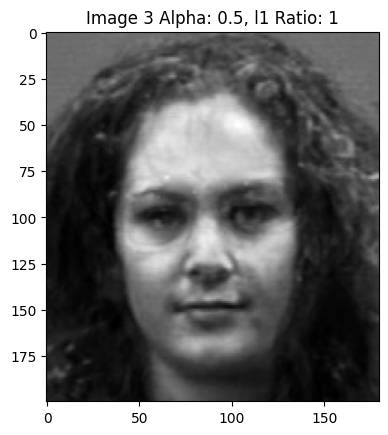

In [32]:
# Implement prob 4 here
results = prob4()

In [33]:
print(results)

{'alpha': 0.0, 'l1_ratio': 1, 'error': np.float64(2537.453766309578)}


The parameters that reconstruct the face the best are:

alpha: 0.0, l1_ratio: 1



## Problem 5

In [40]:
def prob5(best):
    """Find the 10 basis faces with the largest coefficients corresponding 
    to the the 2nd and 12th faces in the dataset. Plot these basis faces 
    along with the original image using subplots
    """
    images = get_faces()
    alpha = best['alpha']
    ratio = best['l1_ratio']

    # Decompose using NMF
    model = NMF(n_components=75, alpha_W = alpha, l1_ratio = ratio, max_iter=1000, init='random')
    W = model.fit_transform(images)
    H = model.components_

    coeffs_2 = H[:, 1]
    coeffs_12 = H[:, 11]

    basis_index_2 = np.argsort(coeffs_2)[-10:][::-1]
    basis_index_12 = np.argsort(coeffs_12)[-10:][::-1]


    # Scale image
    images = images / 255

    # Plot for face 2
    plt.figure()
    plt.subplot(3, 4, 1)
    plt.imshow(images[:, 1].reshape(200, 180), cmap='gray')
    plt.title(f"Original Face 2")
    plt.axis('off')

    # Plots for eigen faces
    for i, idx in enumerate(basis_index_2, start = 2):
        plt.subplot(3, 4, i)
        plt.imshow(W[:, idx].reshape(200, 180), cmap='gray')
        plt.title(f"Basis {idx+1}")
        plt.axis('off')
    plt.suptitle("Top 10 Basis Faces for Face 2")
    plt.show()



    # Plot for face 12
    plt.figure()
    plt.subplot(3, 4, 1)
    plt.imshow(images[:, 11].reshape(200, 180), cmap='gray')
    plt.title(f"Original Face 12")
    plt.axis('off')

    # Plots for eigenfaces
    for i, idx in enumerate(basis_index_12, start = 2):
        plt.subplot(3, 4, i)
        plt.imshow(W[:, idx].reshape(200, 180), cmap='gray')
        plt.title(f"Basis {idx+1}")
        plt.axis('off')
    plt.suptitle("Top 10 Basis Faces for Face 12")
    plt.show()

    


    

    

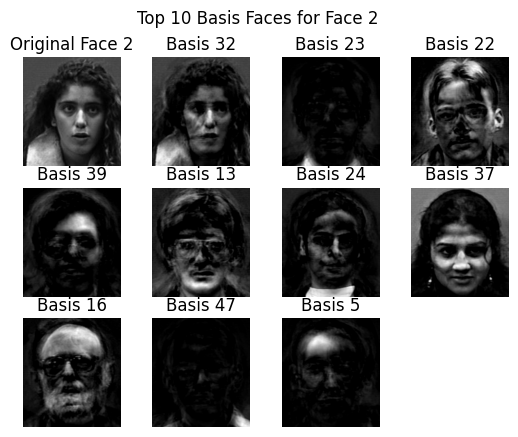

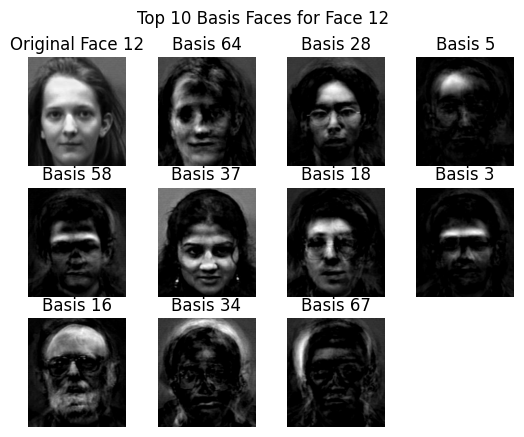

In [41]:
# Implement prob 5 here
prob5(results)